# Description synthétique du projet et de ses objectifs

text

# Installation

In [ ]:
%%capture
!pip install mlflow
!databricks configure --host https://community.cloud.databricks.com/

# Importation

In [ ]:
import zipfile
import os
import h5py
import shutil
import urllib.request
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import random
#import timm
import numpy as np
import cv2
from tensorflow.keras import layers, models, optimizers
import matplotlib.image as mpimg
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16, VGG19, Xception, ResNet50
import mlflow

import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

# Chargement des données

### CFG

In [ ]:
class CFG:

  size = 224
  #batch_size_number= 12
  class_mode = 'sparse'
  batch_size = 12
  patience = 3
  epochs = 5
  seed = 42
  loss = 'sparse_categorical_crossentropy'
 # optimizer = ''
  metrics = 'sparse_categorical_accuracy'
  models_list = [VGG16, VGG19, Xception, ResNet50]
  model_names = ['VGG16', 'VGG19', 'Xception', 'ResNet50']

  path_current = '/content/drive/MyDrive/Bihar-project/Corn-project/'
  zip_file_path = f'{path_current}data/archive.zip'
  extract_folder = f'{path_current}data/'
  train = 'Treino'
  val = 'Valida'
  test = 'Teste'
  train_model_path = f'{path_current}data/ImagensTCCRotuladas/ImagensTCCRotuladas/{train}/'
  eval_model_path = f'{path_current}data/ImagensTCCRotuladas/ImagensTCCRotuladas/{val}/'
  test_model_path = f'{path_current}data/ImagensTCCRotuladas/ImagensTCCRotuladas/{test}/'
  training_histories = '/content/drive/MyDrive/Bihar-project/Corn-project/model/'
  delete_path = '/content/drive/MyDrive/Bihar-project/Corn-project/data/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino/'
  delete_path_val = '/content/drive/MyDrive/Bihar-project/Corn-project/data/ImagensTCCRotuladas/ImagensTCCRotuladas/Valida/'




## unzip_file

In [ ]:
def unzip_file(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      #Extract all the contents to the specified directory
      zip_ref.extractall(extract_to)


unzip_file(CFG.zip_file_path, CFG.extract_folder)

# Analyse exploratoire des données

In [ ]:
def display_img(train_path_folder, title, num_images):
    image_files = os.listdir(train_path_folder)

    num_images_to_display = num_images


    plt.figure(figsize=(15, 5))
    for i in range(num_images_to_display):
        # Chemin complet de l'image
        img_path = os.path.join(train_path_folder, image_files[i])

        img = mpimg.imread(img_path)

        plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
        plt.imshow(img)
        plt.suptitle(title, fontsize=16)
        plt.axis('off')

    plt.show()

In [ ]:
def display_img_type(path_img, img_type, nb):
  display_img(f'{path_img}Hervas',f' Plantes herbacées / {img_type}' ,nb)
  display_img(f'{path_img}Chao',f' Sol sec sans végétation / {img_type}' ,nb)
  display_img(f'{path_img}Milho',f'Végétation de maïs / {img_type}' ,nb)
  display_img(f'{path_img}Milho_ervas',f' Végétation de maïs herbacées / {img_type}' ,nb)




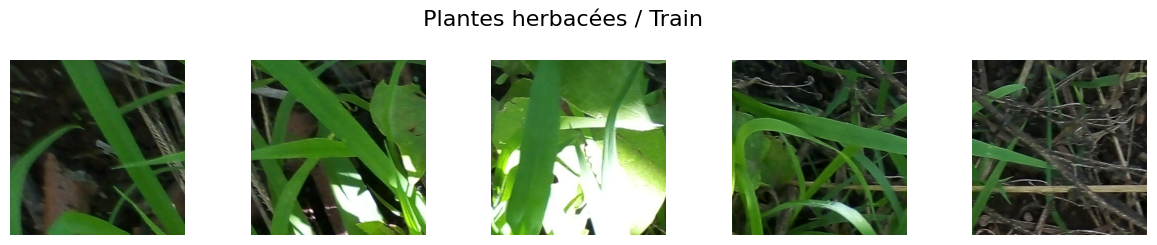

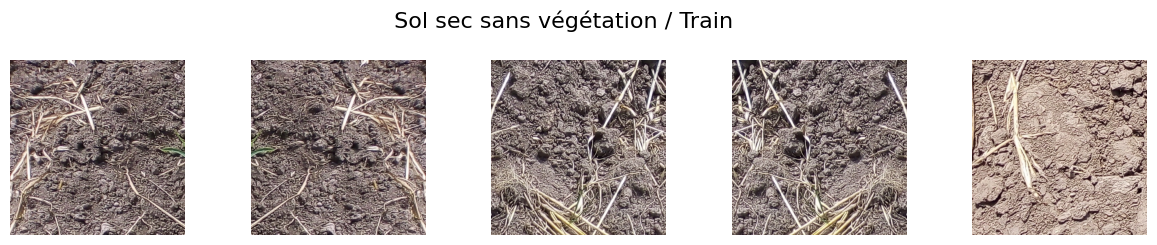

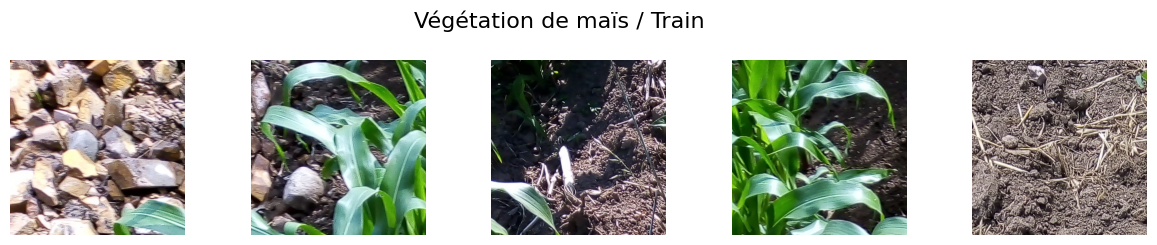

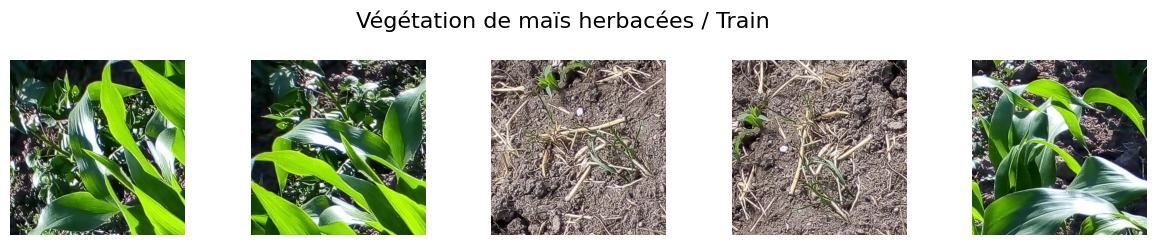

In [ ]:
display_img_type(CFG.train_model_path, 'Train',5)


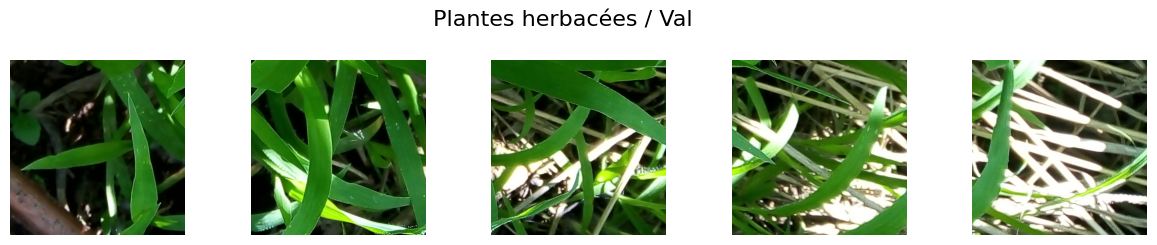

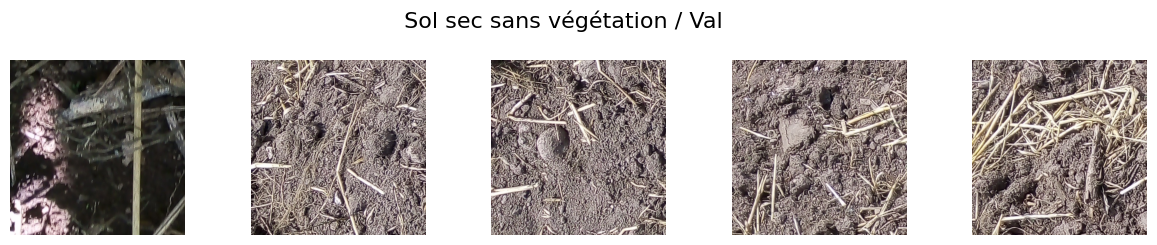

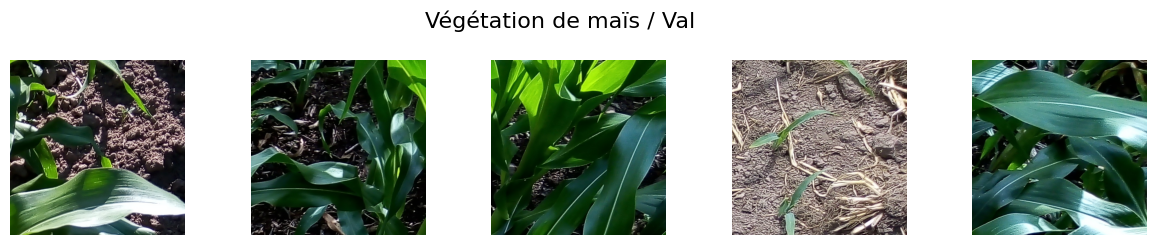

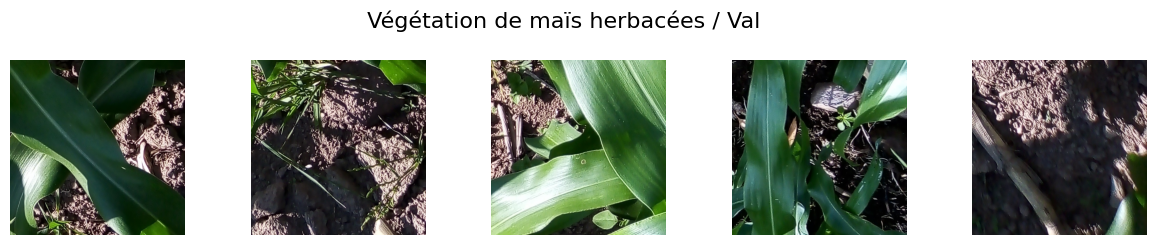

In [ ]:
display_img_type(CFG.eval_model_path, 'Val',5)

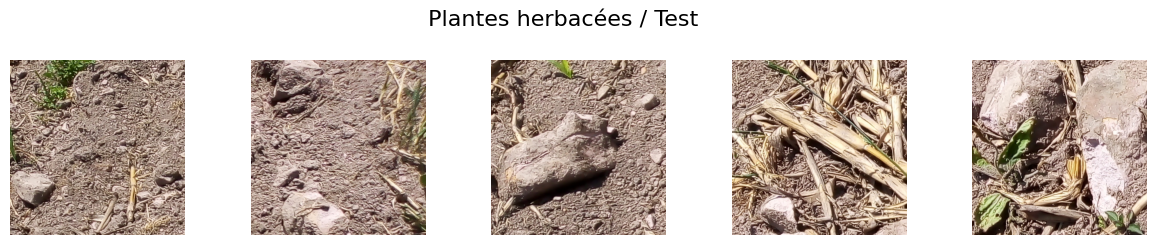

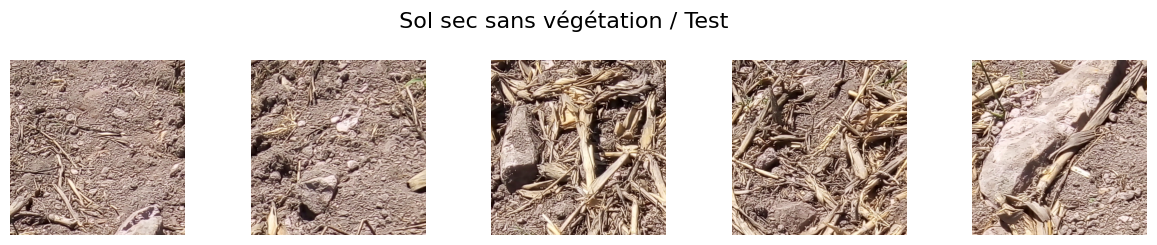

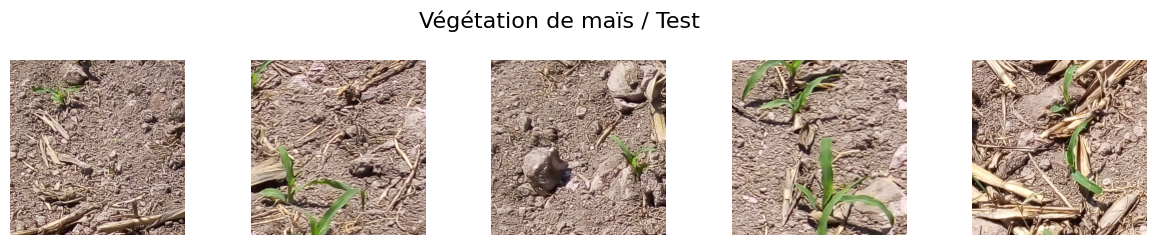

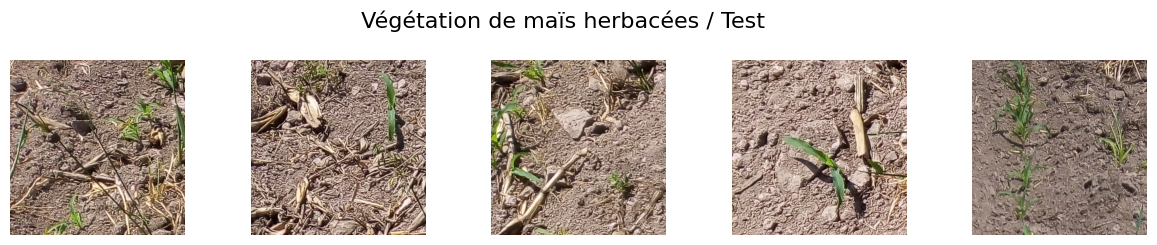

In [ ]:
display_img_type(CFG.test_model_path, 'Test',5)

In [ ]:
import random
from matplotlib.cm import get_cmap

# Randomly choose 4 image paths
random_image_paths = random.sample(df['Path'].tolist(), 4)



# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Get the "jet" colormap
cmap = get_cmap('jet')

# Iterate over the selected image paths
for i, image_path in enumerate(random_image_paths):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Flatten the image to a 1D array
    pixels = image.flatten()

    # Plot the image
    axes[0, i].imshow(image, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Image {i+1}')

    # Plot the pixel distribution with colors from the "jet" colormap
    axes[1, i].hist(pixels, bins=20, color=cmap(i / 4))
    axes[1, i].set_xlabel('Valeur des pixels')
    axes[1, i].set_ylabel('Fréquence')
    axes[1, i].set_title(f'Distribution des pixels - Image {i+1}')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

# Prétraitement des données

## Delete data by class

In [ ]:
class utils:

  def count_files_in_folders(directory_path):
      folder_counts = {}
      for root, dirs, files in os.walk(directory_path):
          folder_name = os.path.basename(root)
          file_count = len(files)
          folder_counts[folder_name] = file_count
      return folder_counts

  def delete_files_in_folders(directory_path, num_files_to_delete):
      for root, dirs, files in os.walk(directory_path):
          if files:
              for _ in range(num_files_to_delete):
                  try:
                      file_to_delete = random.choice(files)
                      file_path = os.path.join(root, file_to_delete)
                      os.remove(file_path)
                      print(f"Deleted file: {file_path}")
                  except FileNotFoundError:
                      print(f"Skipping non-existent file: {file_path}")
                  except Exception as e:
                      print(f"An error occurred: {str(e)}")


In [ ]:
folder_counts = utils.count_files_in_folders(CFG.delete_path)
folder_counts_val = utils.count_files_in_folders(CFG.delete_path_val)

for folder, count in folder_counts.items():
    print(f"Folder Train '{folder}' contains {count} files.")

for folder, count in folder_counts_val.items():
    print(f"Folder Test '{folder}' contains {count} files.")

Folder Train '' contains 0 files.
Folder Train 'Chao' contains 797 files.
Folder Train 'Ervas' contains 700 files.
Folder Train 'Milho' contains 858 files.
Folder Train 'Milho_ervas' contains 731 files.
Folder Test '' contains 0 files.
Folder Test 'Chao' contains 47 files.
Folder Test 'Ervas' contains 61 files.
Folder Test 'Milho' contains 77 files.
Folder Test 'Milho_ervas' contains 68 files.


In [ ]:
num_files_to_delete = 500
num_files_to_delete_val = 10

utils.delete_files_in_folders(CFG.delete_path, num_files_to_delete)
utils.delete_files_in_folders(CFG.delete_path_val, num_files_to_delete_val)

Deleted file: /content/drive/MyDrive/Bihar-project/Corn-project/data/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino/Chao/Imagem_02651_Tc.jpg
Deleted file: /content/drive/MyDrive/Bihar-project/Corn-project/data/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino/Chao/Imagem_00936_Tc.jpg
Deleted file: /content/drive/MyDrive/Bihar-project/Corn-project/data/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino/Chao/Imagem_02899_Tc.jpg
Deleted file: /content/drive/MyDrive/Bihar-project/Corn-project/data/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino/Chao/Imagem_01405_Tc.jpg
Deleted file: /content/drive/MyDrive/Bihar-project/Corn-project/data/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino/Chao/Imagem_05328_D3.jpg
Deleted file: /content/drive/MyDrive/Bihar-project/Corn-project/data/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino/Chao/Imagem_02784_Tc.jpg
Deleted file: /content/drive/MyDrive/Bihar-project/Corn-project/data/ImagensTCCRotuladas/ImagensTCCRotuladas/Treino/Chao/Imagem_02905_T1.jpg
Deleted file:

## ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


val_datagen = ImageDataGenerator(rescale=1./255)

## datagen

In [ ]:
train_generator = train_datagen.flow_from_directory(
        CFG.train_model_path,
        target_size=(CFG.size, CFG.size),
        batch_size=CFG.batch_size,
        class_mode=CFG.class_mode,
        seed=CFG.seed
        )

validation_generator = val_datagen.flow_from_directory(
        CFG.eval_model_path,
        target_size=(CFG.size, CFG.size),
        batch_size=CFG.batch_size,
        class_mode=CFG.class_mode,
        seed=CFG.seed)

test_generator = val_datagen.flow_from_directory(
        CFG.test_model_path,
        target_size=(CFG.size, CFG.size),
        batch_size=CFG.batch_size,
        class_mode=CFG.class_mode,
        shuffle=False)

Found 3086 images belonging to 4 classes.
Found 253 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


# Modélisation et évaluation des perfo rmances des modèles

# Baseline

### Model

In [ ]:
def base_pretrained_model(pretrained_model):
    base_model = pretrained_model(weights='imagenet', include_top=False, input_shape=(CFG.size, CFG.size, 3))
    # Freeze the base model layers
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='softmax')  # Corrected the number of units to match the number of classes
    ])

    # Compile the model
    model.compile(
        loss=CFG.loss,
        optimizer=optimizers.Adam(),
        metrics=CFG.metrics
    )

    return model


### Trainning

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=CFG.patience,
    restore_best_weights=True
)


steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

results = {'Model': [], 'Loss': [], 'Accuracy': [], 'Val_loss': [], 'Val_accuracy': []}

for model, model_name in zip(CFG.models_list, CFG.model_names):
    based_model = base_pretrained_model(model)

    history = based_model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=CFG.epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[early_stopping]  # Include the EarlyStopping callback
    )

    # Save the trained model
    model_save_path = os.path.join('model_checkpoints', f'{model_name}_model.h5')
    based_model.save(model_save_path)

    # Save the training history
    history_save_path = os.path.join(CFG.training_histories, f'{model_name}_history.csv')
    pd.DataFrame(history.history).to_csv(history_save_path, index=False)

    # Save results
    results['Model'].append(model_name)
    results['Loss'].append(history.history['loss'][-1])
    results['Accuracy'].append(history.history['sparse_categorical_accuracy'][-1])  # Corrected key here
    results['Val_loss'].append(history.history['val_loss'][-1])
    results['Val_accuracy'].append(history.history['val_sparse_categorical_accuracy'][-1])  # Corrected key here

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(f'{path_current}data/pretrained_model_results.csv', index=False)

print("Results saved successfully.")



Epoch 1/5
171/171 [==============================] - 24s 126ms/step - loss: 1.0877 - sparse_categorical_accuracy: 0.5455 - val_loss: 0.8694 - val_sparse_categorical_accuracy: 0.6154
Epoch 2/5
171/171 [==============================] - 21s 123ms/step - loss: 0.9185 - sparse_categorical_accuracy: 0.5943 - val_loss: 0.8417 - val_sparse_categorical_accuracy: 0.5513
Epoch 3/5
171/171 [==============================] - 21s 125ms/step - loss: 0.8334 - sparse_categorical_accuracy: 0.6383 - val_loss: 0.7744 - val_sparse_categorical_accuracy: 0.6795
Epoch 4/5
171/171 [==============================] - 20s 118ms/step - loss: 0.8164 - sparse_categorical_accuracy: 0.6388 - val_loss: 0.7967 - val_sparse_categorical_accuracy: 0.6410
Epoch 5/5
171/171 [==============================] - 21s 124ms/step - loss: 0.7990 - sparse_categorical_accuracy: 0.6593 - val_loss: 0.8070 - val_sparse_categorical_accuracy: 0.7308


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
171/171 [==============================] - 22s 124ms/step - loss: 1.1287 - sparse_categorical_accuracy: 0.5083 - val_loss: 0.9530 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/5
171/171 [==============================] - 21s 122ms/step - loss: 0.9318 - sparse_categorical_accuracy: 0.5870 - val_loss: 0.9010 - val_sparse_categorical_accuracy: 0.6154
Epoch 3/5
171/171 [==============================] - 21s 126ms/step - loss: 0.8912 - sparse_categorical_accuracy: 0.6061 - val_loss: 0.8910 - val_sparse_categorical_accuracy: 0.5897
Epoch 4/5
171/171 [==============================] - 22s 128ms/step - loss: 0.8483 - sparse_categorical_accuracy: 0.6163 - val_loss: 0.8932 - val_sparse_categorical_accuracy: 0.6026
Epoch 5/5
171/171 [==============================] - 21s 125ms/step - loss: 0.8397 - sparse_categorical_accuracy: 0.6256 - val_loss: 0.8452 - val_sparse_categorical_accuracy: 0.5897


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/5
171/171 [==============================] - 26s 134ms/step - loss: 1.7296 - sparse_categorical_accuracy: 0.5068 - val_loss: 1.1487 - val_sparse_categorical_accuracy: 0.4231
Epoch 2/5
171/171 [==============================] - 22s 126ms/step - loss: 1.0861 - sparse_categorical_accuracy: 0.5714 - val_loss: 1.1404 - val_sparse_categorical_accuracy: 0.4615
Epoch 3/5
171/171 [==============================] - 22s 129ms/step - loss: 0.9758 - sparse_categorical_accuracy: 0.5855 - val_loss: 1.0480 - val_sparse_categorical_accuracy: 0.4872
Epoch 4/5
171/171 [==============================] - 21s 123ms/step - loss: 0.9664 - sparse_categorical_accuracy: 0.5978 - val_loss: 1.1012 - val_sparse_categorical_accuracy: 0.5897
Epoch 5/5
171/171 [==============================] - 22s 128ms/step - loss: 0.8720 - sparse_categorical_accuracy: 0.6232 - val_loss: 1.1153 - val_sparse_categorical_accuracy: 0.5000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/5
171/171 [==============================] - 28s 133ms/step - loss: 1.6831 - sparse_categorical_accuracy: 0.3514 - val_loss: 1.2988 - val_sparse_categorical_accuracy: 0.4487
Epoch 2/5
171/171 [==============================] - 22s 128ms/step - loss: 1.2924 - sparse_categorical_accuracy: 0.3949 - val_loss: 1.2266 - val_sparse_categorical_accuracy: 0.3718
Epoch 3/5
171/171 [==============================] - 21s 124ms/step - loss: 1.2349 - sparse_categorical_accuracy: 0.4047 - val_loss: 1.1786 - val_sparse_categorical_accuracy: 0.4487
Epoch 4/5
171/171 [==============================] - 22s 129ms/step - loss: 1.2122 - sparse_categorical_accuracy: 0.4189 - val_loss: 1.1923 - val_sparse_categorical_accuracy: 0.4103
Epoch 5/5
171/171 [==============================] - 21s 123ms/step - loss: 1.2189 - sparse_categorical_accuracy: 0.4282 - val_loss: 1.1699 - val_sparse_categorical_accuracy: 0.4359


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Results saved successfully.


In [ ]:
results_df.head()

Model      Loss  Accuracy  Val_loss  Val_accuracy
0     VGG16  0.798961  0.659335  0.807008      0.730769
1     VGG19  0.839671  0.625611  0.845200      0.589744
2  Xception  0.872039  0.623167  1.115320      0.500000
3  ResNet50  1.218934  0.428153  1.169932      0.435897

# Turning

In [ ]:
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("<Enter your copied experiment name here>")

In [ ]:
def custom_pretrained_model(pretrained_model, optimizers):
    base_model = pretrained_model(weights='imagenet', include_top=False, input_shape=(CFG.size, CFG.size, 3))
    # Freeze the base model layers
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(4, activation='softmax')  # Corrected the number of units to match the number of classes
    ])

    # Compile the model
    model.compile(
        loss=CFG.loss,
        optimizer=optimizers.Adam(),
        metrics=CFG.metrics
    )

    return model


In [ ]:
def custom_pretrained_model(pretrained_model, optimizer, dropout_rate):
    base_model = pretrained_model(weights='imagenet', include_top=False, input_shape=(CFG.size, CFG.size, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(4, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['sparse_categorical_accuracy']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=CFG.patience,
    restore_best_weights=True
)

optimizers = [tf.keras.optimizers.legacy.Adam(), tf.keras.optimizers.legacy.RMSprop(), tf.keras.optimizers.legacy.Adagrad()]


dropout_rates = [0.0, 0.2, 0.3, 0.4]

for optimizer in optimizers:
    for dropout_rate in dropout_rates:
        model_name = f'VGG16_{optimizer.__class__.__name__}_dropout_{dropout_rate}'
        based_model = custom_pretrained_model(VGG16, optimizer, dropout_rate)



        history = based_model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            epochs=CFG.epochs,
            validation_data=validation_generator,
            validation_steps=len(validation_generator),
            callbacks=[early_stopping]
        )

        # Save the trained model
        model_save_path = os.path.join('model_checkpoints', f'{model_name}_{optimizer}_{dropout_rate}model.h5')
        based_model.save(model_save_path)

        # Save the training history
        history_save_path = os.path.join(CFG.training_histories, f'{model_name}_history.csv')
        pd.DataFrame(history.history).to_csv(history_save_path, index=False)

print("Training completed.")


Epoch 1/5
258/258 [==============================] - 76s 268ms/step - loss: 1.4430 - sparse_categorical_accuracy: 0.5671 - val_loss: 0.9199 - val_sparse_categorical_accuracy: 0.5968
Epoch 2/5
258/258 [==============================] - 69s 267ms/step - loss: 0.7941 - sparse_categorical_accuracy: 0.6598 - val_loss: 0.8808 - val_sparse_categorical_accuracy: 0.5968
Epoch 3/5
258/258 [==============================] - 70s 271ms/step - loss: 0.7144 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.7687 - val_sparse_categorical_accuracy: 0.6522
Epoch 4/5
258/258 [==============================] - 81s 312ms/step - loss: 0.6745 - sparse_categorical_accuracy: 0.7100 - val_loss: 0.7267 - val_sparse_categorical_accuracy: 0.6917
Epoch 5/5
258/258 [==============================] - 76s 295ms/step - loss: 0.6597 - sparse_categorical_accuracy: 0.7178 - val_loss: 0.7201 - val_sparse_categorical_accuracy: 0.6601
Epoch 1/5
258/258 [==============================] - 71s 272ms/step - loss: 2.9685 - spars

# Analyse et interprétation des résultats obtenus

## Train & Val

In [ ]:
def get_training_metrics(history):

  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history

  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

In [ ]:
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()


In [ ]:
plot_train_eval(history)

## Test

In [ ]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_imbalanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

## Mlflow Databricks

In [ ]:
def custom_pretrained_model(pretrained_model, optimizer, dropout_rate):
    base_model = pretrained_model(weights='imagenet', include_top=False, input_shape=(CFG.size, CFG.size, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(4, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['sparse_categorical_accuracy']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=CFG.patience,
    restore_best_weights=True
)

optimizers = [optimizers.Adam(), optimizers.RMSprop(), optimizers.Adagrad()]

dropout_rates = [0.0, 0.2, 0.3, 0.4]

with mlflow.start_run():
    for optimizer in optimizers:
        for dropout_rate in dropout_rates:
            model_name = f'VGG16_{optimizer.__class__.__name__}_dropout_{dropout_rate}'
            based_model = custom_pretrained_model(VGG16, optimizer, dropout_rate)

            history = based_model.fit(
                train_generator,
                steps_per_epoch=len(train_generator),
                epochs=CFG.epochs,
                validation_data=validation_generator,
                validation_steps=len(validation_generator),
                callbacks=[early_stopping]
            )

            # Log parameters
            mlflow.log_param("Model", model_name)
            mlflow.log_param("Optimizer", optimizer.__class__.__name__)
            mlflow.log_param("Dropout Rate", dropout_rate)

            # Log metrics
            mlflow.log_metric("Loss", history.history['loss'][-1])
            mlflow.log_metric("Accuracy", history.history['sparse_categorical_accuracy'][-1])
            mlflow.log_metric("Val_loss", history.history['val_loss'][-1])
            mlflow.log_metric("Val_accuracy", history.history['val_sparse_categorical_accuracy'][-1])

            # Save the trained model
            model_save_path = os.path.join('model_checkpoints', f'{model_name}_{optimizer}_{dropout_rate}model.h5')
            based_model.save(model_save_path)

            # Save the training history
            history_save_path = os.path.join(CFG.training_histories, f'{model_name}_history.csv')
            pd.DataFrame(history.history).to_csv(history_save_path, index=False)

print("MLflow run completed.")
